# 3. Beamforming for location

This notebook computes the beamformed network response and demonstrates how to use it for the detection and location of an eathquake. The workflow consists of computing waveform features first (envelopes, kurtosis, etc.) and, then, to shift-and-stack them according to the previously computed travel times.

## Contents

* [Compute waveform features](#compute-waveform-features)

* [Read travel times](#read-travel-times)

* [Show an example waveform](#show-an-example-envelope)

In [1]:
import beampower as bp
import glob
import numpy as np
import os
import pandas as pd
import tqdm
import xarray as xr

from matplotlib import pyplot as plt
from scipy import signal, stats
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import locations2degrees, degrees2kilometers

In [2]:
%load_ext autoreload
%autoreload 2

## Compute waveform features

The underlying paradigm of the beamforming method is that when using the exact travel times to align the traces, they sum up to the largest amplitude beam. However, the waves emitted by a double-couple source may sum up to zero due to antisymmetries in the radiated wavefield. Furthermore, imprecisions in the velocity model and the finiteness of the grid often mean that the exact travel times are not available in the pre-computed travel time grid.


To address the aforementionned drawbacks, we compute positive-valued *waveform features* to handle antisymmetries in the wavefield and we make sure that they are smooth enough in time to be correctly aligned by at least one set of pre-computed travel times (think of trying, unsuccesfully, to align Diracs with a finite resolution travel time grid!).

Here, we use the waveform envelopes. The envelope is computed from the analytical signal (Hilbert transform). To avoid noisy stations from dominating the beams, we normalize each trace by its median absolute deviation. The envelopes are clipped above $10^5$ times the mean absolute deviation in order to avoid spikes or proximal transient noise to corrupt the beams.

In [3]:
def envelope(x):
    """Envelope transformation.

    Calculate the envelope of the input one-dimensional signal with the Hilbert
    transform. The data is normalized by the mean absolute deviation over the
    entire signal window first. The envelope is clipped at a maximum of 10^5
    times the mad of the envelope.
    
    Arguments
    ---------
    x: array-like
        The input one-dimensional signal.
    
    Returns
    -------
    array-like
        The envelope of x with same shape than x.
    """
    # Normalization
    x_mad = stats.median_abs_deviation(x)
    x_mad = 1.0 if x_mad == 0.0 else x_mad

    # Envelope
    x = np.abs(signal.hilbert(x / x_mad))
    
    # Clip
    x_max = 10.0 ** (5.0 * stats.median_abs_deviation(x))
    return x.clip(None, x_max)

We first initialize the waveform features as a `DataArray` in order to keep explicit indexing.

In [4]:
DIRPATH_INVENTORY = "../data/processed/*.xml"
DIRPATH_WAVEFORMS = "../data/processed/*.mseed"

# Header
filepaths_waveforms = glob.glob(DIRPATH_WAVEFORMS)
headers = read(DIRPATH_WAVEFORMS, headonly=True)

# Initialize
waveform_features = xr.DataArray(
    dims=["station", "channel", "time"],
    coords={
        "channel": list(set([header.stats.channel[-1] for header in headers])),
        "station": list(set([header.stats.station for header in headers])),
        "time": pd.to_datetime(headers[0].times("timestamp"), unit="s")
    }
)

# Transform each file
for trace in tqdm.tqdm(read(DIRPATH_WAVEFORMS), desc="Envelopes"):
    info = trace.stats
    index = {"station": info.station, "channel": info.channel[-1]}
    waveform_features.loc[index] = envelope(trace.data)


Envelopes: 100%|██████████| 24/24 [00:10<00:00,  2.39it/s]


## Show an example envelope

Example of a waveform with corresponding envelope.

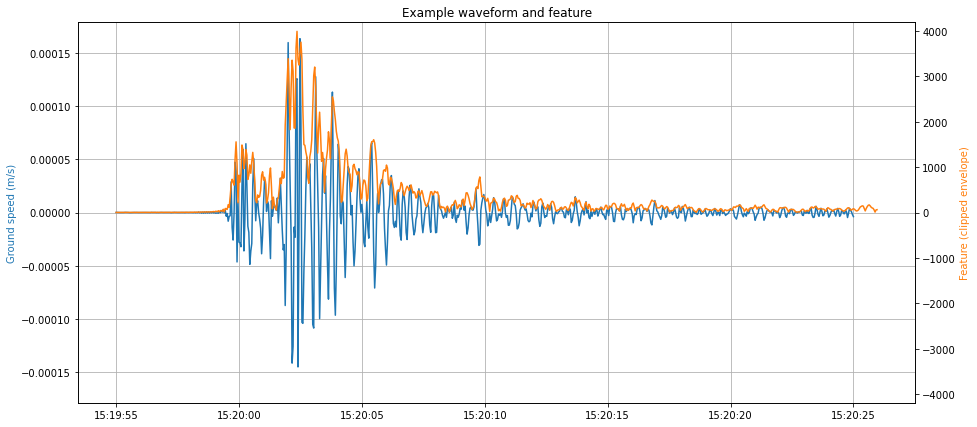

In [6]:
START, END = "2013-04-23 15:19:55", "2013-04-23 15:20:25"

# Get example waveform
trace = read(filepaths_waveforms[2])[0]
trace.trim(starttime=UTCDateTime(START), endtime=UTCDateTime(END))
times = pd.to_datetime(trace.times("timestamp"), unit="s")

# Plot waveform
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(times, trace.data)
ymax = max(np.abs(ax.get_ylim()))
ax.set_ylim(-ymax, ymax)
ax.set_ylabel("Ground speed (m/s)", color="C0")
ax.set_title("Example waveform and feature")
ax.grid()

# Plot envelope on a second axe (not the same scale)
ax = ax.twinx()
waveform_features.sel(
    station=trace.stats.station,
    channel=trace.stats.channel[-1],
    time=slice(START, END),
).plot(ax=ax, color="C1")

# Labels
ax.set_ylabel("Feature (clipped envelope)", color="C1")
ax.set_ylim(bottom=-max(ax.get_ylim()))
ax.set_title("")
plt.show()

## Initialize beamforming

Get the travel times obtained from [our notebook #2](2_travel_times.ipynb) on travel time computation.

In [7]:
ravel_shape = ["latitude", "longitude", "depth"]
sampling_rate = headers[0].stats.sampling_rate

# Time delays
travel_times = xr.load_dataarray("../data/travel_times.nc")
time_delays = travel_times.stack(source=ravel_shape)
time_delays = time_delays.transpose("source", "station", "phase")
time_delays = np.round(sampling_rate * time_delays)

# Phase weights
weights_phase = xr.ones_like(waveform_features.isel(time=0).drop("time"))
weights_phase = weights_phase.expand_dims({"phase": 2})
weights_phase = weights_phase.assign_coords({"phase": list("PS")})
weights_phase = weights_phase.copy()
weights_phase.loc[{"channel": ["E", "N"], "phase": "P"}] = 0.0
weights_phase.loc[{"channel": "Z", "phase": "S"}] = 0.0
weights_phase = weights_phase.transpose("station", "channel", "phase")

# Sources weights
weights_sources = np.ones(time_delays.shape[:-1])

## Compute the beamformed network response

At each time step, we compute the beamformed network response for every grid point and keep the maximum. We thus obtain a time series of maximum beams at every time.

In [8]:
beam_max, beam_argmax = bp.beamform(
    waveform_features.to_numpy(),
    time_delays.to_numpy(),
    weights_phase.to_numpy(),
    weights_sources,
    device="cpu",
    reduce="max",
)

## Aggregate beam outputs

The output of the beamforming operation are assembled in a `Dataarray` in order to simplify array manipulation and detection.

In [9]:
# Get arrays
beam = xr.DataArray(data=beam_max, coords=waveform_features["time"].coords)
beam = beam.to_dataset(name="beam_max")

# Source coordinates
for dim in ravel_shape:
    beam_max_coords = time_delays[dim].to_numpy()[beam_argmax]
    beam = beam.assign({dim: ("time", beam_max_coords)})

beam

<xarray.Dataset>
Dimensions:    (time: 2160000)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-23 ... 2013-04-23T23:59:59.960000
Data variables:
    beam_max   (time) float32 2.756e-11 2.793e-11 2.845e-11 ... 0.0 0.0 0.0
    latitude   (time) float64 40.76 40.7 40.69 40.76 ... 40.76 40.76 40.76 40.76
    longitude  (time) float64 30.45 30.44 30.44 30.45 ... 30.2 30.2 30.2 30.2
    depth      (time) float64 30.0 30.0 30.0 30.0 30.0 ... 30.0 30.0 30.0 30.0

## Detect

We detect the maxima with find peaks and use a threshold criterion to keep only the prominent peaks (or events).

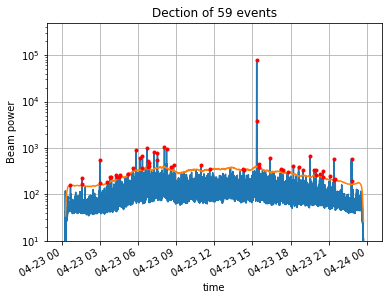

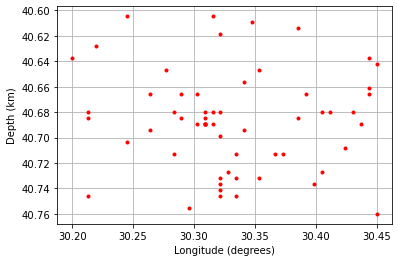

In [10]:
MIN_DETECTION_INTERVAL = int(30 * sampling_rate)

# Detect
peaks = signal.find_peaks(beam.beam_max, distance=MIN_DETECTION_INTERVAL)
events = beam.isel(time=peaks[0])

# Threshold
window_length = int(1800 * sampling_rate)
threshold = 3 * beam.beam_max.rolling(time=window_length, center=True).median()
beam = beam.assign({"threshold": ("time", threshold.to_numpy())})
events = events.isel(time=events.beam_max > threshold)

# Show
beam.beam_max.plot()
threshold.plot()
events.beam_max.plot(marker=".", ls="none", c="r")
plt.semilogy()
plt.ylim(bottom=10)
plt.ylabel("Beam power")
plt.grid()
plt.title(f"Detection of {len(events.time)} events")
plt.show()

plt.plot(events.longitude, events.latitude, ".r")
plt.xlabel("Longitude (degrees)")
plt.ylabel("Depth (km)")
plt.gca().invert_yaxis()
plt.grid()

## Show detection

We detect the maxima with find peaks and use a threshold criterion to keep only the prominent peaks (or events).

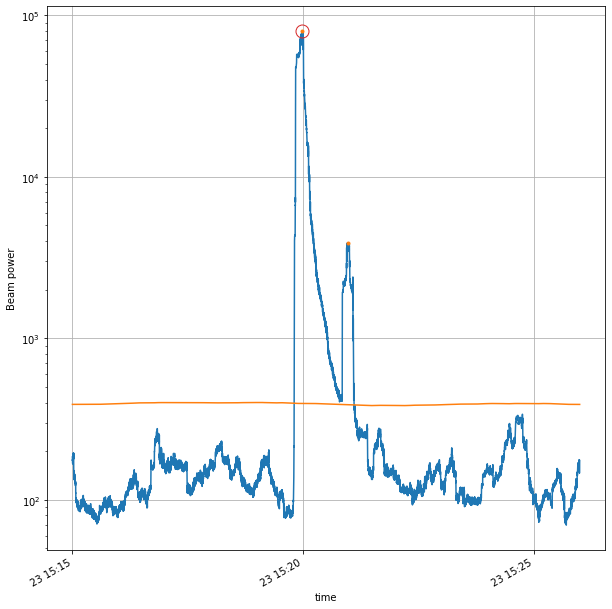

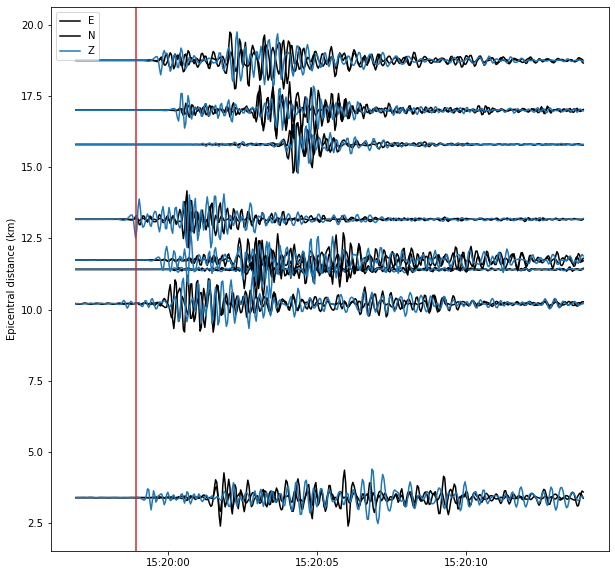

In [17]:
COLORS = {"E": "k", "N": "k", "Z": "C0"}
ZOOM = slice("2013-04-23 15:15", "2013-04-23 15:25")

inventory = read_inventory(DIRPATH_INVENTORY)
detector_zoom = beam.sel(time=ZOOM)
events_zoom = events.sel(time=ZOOM)

# Show
fig = plt.figure(figsize=(10, 10))
detector_zoom.beam_max.plot()
detector_zoom.threshold.plot()
events_zoom.beam_max.plot(marker=".", ls="none", c="C1")
plt.semilogy()
plt.grid()
plt.ylabel("Beam power")

# Watch peak
event_watch = events_zoom.isel(time=events_zoom.beam_max.argmax())
plt.plot(event_watch.time, event_watch.beam_max, "oC3", ms=13, mfc="none")
date = UTCDateTime(str(event_watch.time.data))

# Get waveform
fig, ax = plt.subplots(1, figsize=(10, 10))
for index, trace in enumerate(read(DIRPATH_WAVEFORMS)):

    # Get trace and info
    trace.trim(date - 2, date + 15)        
    trace.filter(type="lowpass", freq=5)
    times = pd.to_datetime(trace.times("timestamp"), unit="s")
    data = trace.data / np.abs(trace.data).max()

    coords = inventory.get_coordinates(trace.id)
    p1 = event_watch.latitude.data, event_watch.longitude.data
    p2 = [coords[dim] for dim in ["latitude", "longitude"]]
    distance = degrees2kilometers(locations2degrees(*p1, *p2))

    # Plot trace
    ax.plot(times, data + distance, color=COLORS[trace.stats.channel[-1]])
    
# Labels
ax.set_ylabel("Epicentral distance (km)")
ax.axvline(date, color="C3")
ax.legend([key for key in COLORS])
    